# Grid Search

In [1]:
import torch
import pandas as pd
import sys
sys.path.append('../src')
from dataset import MURADataset
from model import FractureNet
from evaluate import evaluate_hybrid
from pathlib import Path
from tqdm.auto import tqdm
import random
import numpy as np

current_dir = Path.cwd()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load validation data
valid_df = pd.read_csv(f'{str(current_dir).replace('notebooks','')}/data/valid_image_paths.csv',
                      header=None,
                      names=['path'])
val_data = MURADataset(df=valid_df, data_root='c:/Users/marzk/Documents/Coding/AI/imageClassification/data')
model = FractureNet(backbone='resnet18', pretrained=True)
model.load_state_dict(torch.load(f'{str(current_dir).replace('notebooks','')}best_model.pt', map_location=device))
model.to(device)


c:\Users\marzk\Documents\Coding\AI\imageClassification\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


FractureNet(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [2]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # Ensures deterministic behavior (may slightly reduce speed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
p_lows = [0.18, 0.20, 0.22, 0.24, 0.26]
entropy_maxes = [2.2, 2.6, 3.0, 3.4, 3.8]
area_maxes = [None, 0.30, 0.25, 0.20, 0.15]
alpha = [0.3, 0.4, 0.5, 0.6, 0.7]

set_seed()
rows = []
total = len(p_lows) * len(entropy_maxes) * len(area_maxes) * len(alpha)

with tqdm(total=total, desc='Hybrid grid search') as pbar:
    for p_low in p_lows:
        for emax in entropy_maxes:
            for amax in area_maxes:
                for a in alpha:
                  summary, _ = evaluate_hybrid(
                      model=model,
                      dataset=val_data,
                      device=device,
                      p_low=p_low,
                      entropy_max=emax,
                      area_max=amax,
                      max_items=500,  # speed-up during tuning; remove for final run.
                      alpha = a
                  )

                  rows.append({
                      'p_low': p_low,
                      'entropy_max': emax,
                      'area_max': amax,
                      'alpha': a,
                      'accuracy_conf': summary['accuracy_conf'],
                      'inconclusive_rate': summary['inconclusive_rate'],
                      'precision_conf': summary['precision_conf'],
                      'recall_conf': summary['recall_conf'],
                      'f1_conf': summary['f1_conf'],
                      'counts_neg': summary['counts']['negative'],
                      'counts_pos': summary['counts']['positive'],
                      'counts_inc': summary['counts']['inconclusive'],
                  })

                  pbar.update(1)

df = pd.DataFrame(rows)


Hybrid grid search: 100%|██████████| 625/625 [56:44<00:00,  5.45s/it]


In [14]:
df.sort_values([ 'accuracy_conf'], ascending=[False]).head(20)

,p_low,entropy_max,area_max,alpha,accuracy_conf,inconclusive_rate,precision_conf,recall_conf,f1_conf,counts_neg,counts_pos,counts_inc
603,0.26,3.8,NaN,0.6,0.796000,0.000,0.791541,0.888136,0.837061,169,331,0
604,0.26,3.8,NaN,0.7,0.796000,0.000,0.791541,0.888136,0.837061,169,331,0
602,0.26,3.8,NaN,0.5,0.796000,0.000,0.791541,0.888136,0.837061,169,331,0
600,0.26,3.8,NaN,0.3,0.796000,0.000,0.791541,0.888136,0.837061,169,331,0
601,0.26,3.8,NaN,0.4,0.796000,0.000,0.791541,0.888136,0.837061,169,331,0
614,0.26,3.8,0.25,0.7,0.795591,0.002,0.790909,0.887755,0.836538,169,330,1
609,0.26,3.8,0.30,0.7,0.795591,0.002,0.790909,0.887755,0.836538,169,330,1
608,0.26,3.8,0.30,0.6,0.794355,0.008,0.788991,0.886598,0.834951,169,327,4
613,0.26,3.8,0.25,0.6,0.794297,0.018,0.788820,0.885017,0.834154,169,322,9
619,0.26,3.8,0.20,0.7,0.793103,0.014,0.787037,0.885417,0.833333,169,324,7


In [11]:
df.to_csv('grid_search_output.csv')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style='whitegrid', context='talk')
df['area_max'] = df['area_max'].fillna('None')

df['coverage'] = 1 - df['inconclusive_rate']
df['overall_accuracy_est'] = df['accuracy_conf'] * df['coverage']

df.head()

,p_low,entropy_max,area_max,alpha,accuracy_conf,inconclusive_rate,precision_conf,recall_conf,f1_conf,counts_neg,counts_pos,counts_inc,coverage,overall_accuracy_est
0,0.18,2.2,None,0.3,0.751351,0.63,0.48,0.545455,0.510638,135,50,315,0.37,0.278
1,0.18,2.2,None,0.4,0.751351,0.63,0.48,0.545455,0.510638,135,50,315,0.37,0.278
2,0.18,2.2,None,0.5,0.751351,0.63,0.48,0.545455,0.510638,135,50,315,0.37,0.278
3,0.18,2.2,None,0.6,0.751351,0.63,0.48,0.545455,0.510638,135,50,315,0.37,0.278
4,0.18,2.2,None,0.7,0.751351,0.63,0.48,0.545455,0.510638,135,50,315,0.37,0.278


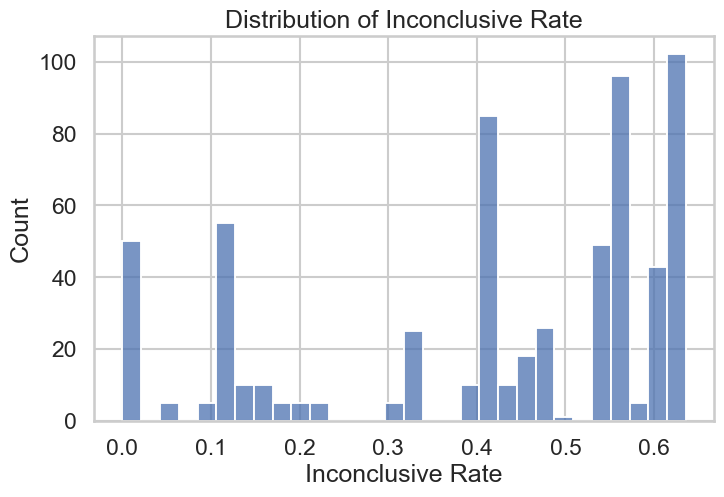

In [16]:
plt.figure(figsize=(8,5))
sns.histplot(df['inconclusive_rate'], bins=30)
plt.title('Distribution of Inconclusive Rate')
plt.xlabel('Inconclusive Rate')
plt.show()


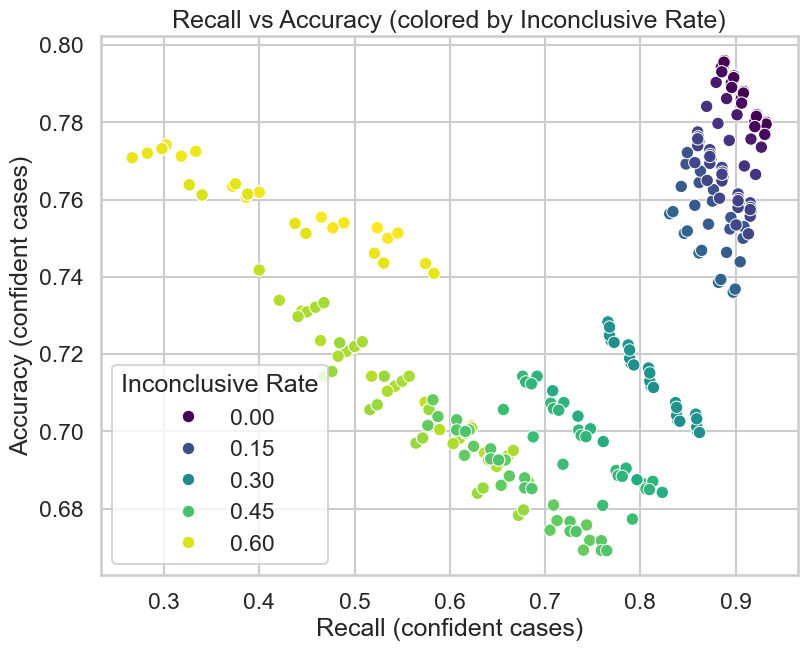

In [17]:
plt.figure(figsize=(9,7))
sns.scatterplot(
    data=df,
    x='recall_conf',
    y='accuracy_conf',
    hue='inconclusive_rate',
    palette='viridis',
    s=80
)
plt.title('Recall vs Accuracy (colored by Inconclusive Rate)')
plt.xlabel('Recall (confident cases)')
plt.ylabel('Accuracy (confident cases)')
plt.legend(title='Inconclusive Rate')
plt.show()


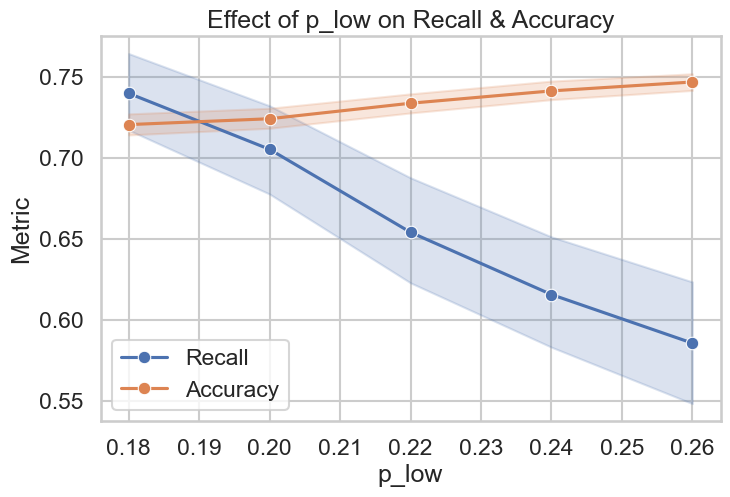

In [23]:
plt.figure(figsize=(8,5))
sns.lineplot(
    data=df,
    x='p_low',
    y='recall_conf',
    marker='o',
    label='Recall'
)
sns.lineplot(
    data=df,
    x='p_low',
    y='accuracy_conf',
    marker='o',
    label='Accuracy'
)
plt.title('Effect of p_low on Recall & Accuracy')
plt.ylabel('Metric')
plt.show()


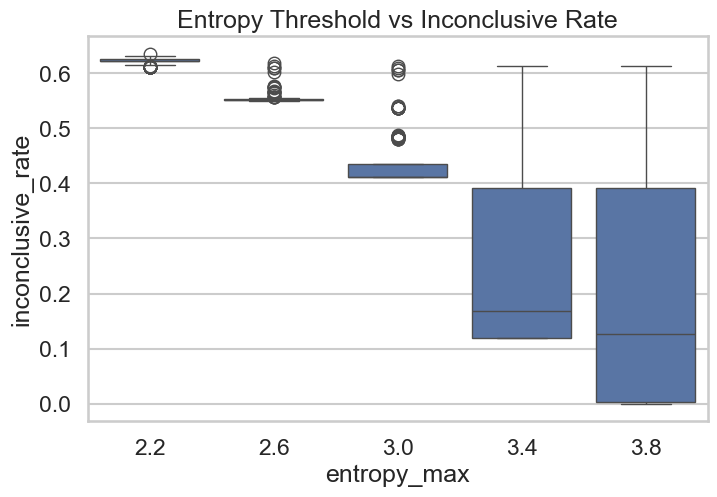

In [25]:
plt.figure(figsize=(8,5))
sns.boxplot(
    data=df,
    x='entropy_max',
    y='inconclusive_rate'
)
plt.title('Entropy Threshold vs Inconclusive Rate')
plt.show()


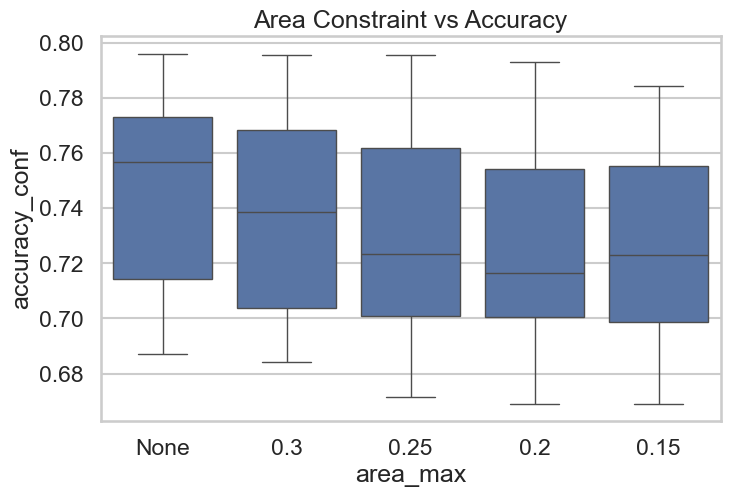

In [26]:
plt.figure(figsize=(8,5))
sns.boxplot(
    data=df,
    x='area_max',
    y='accuracy_conf'
)
plt.title('Area Constraint vs Accuracy')
plt.show()


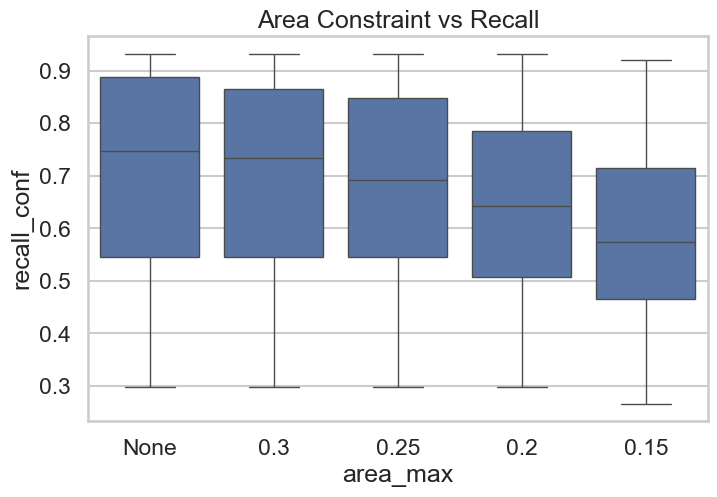

In [27]:
plt.figure(figsize=(8,5))
sns.boxplot(
    data=df,
    x='area_max',
    y='recall_conf'
)
plt.title('Area Constraint vs Recall')
plt.show()


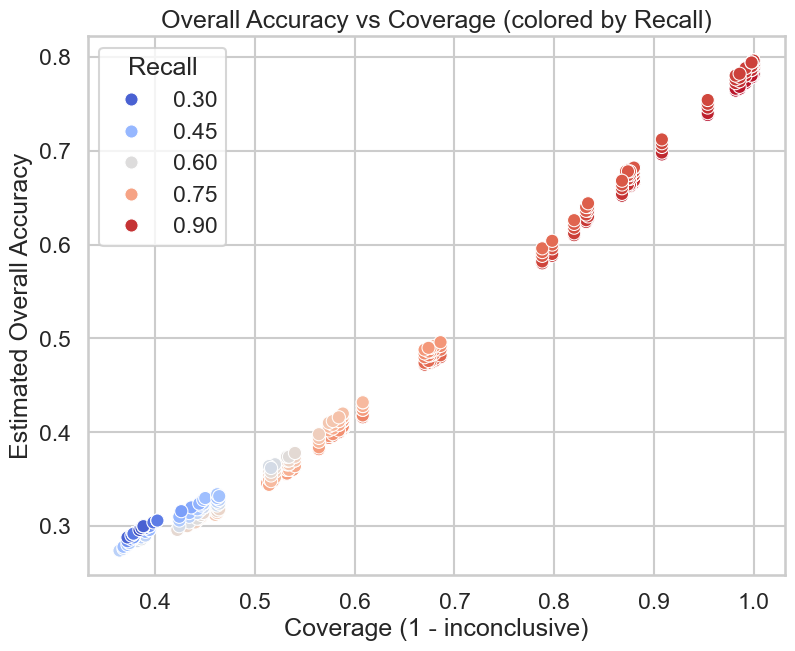

In [28]:
plt.figure(figsize=(9,7))
sns.scatterplot(
    data=df,
    x='coverage',
    y='overall_accuracy_est',
    hue='recall_conf',
    palette='coolwarm',
    s=90
)
plt.title('Overall Accuracy vs Coverage (colored by Recall)')
plt.xlabel('Coverage (1 - inconclusive)')
plt.ylabel('Estimated Overall Accuracy')
plt.legend(title='Recall')
plt.show()


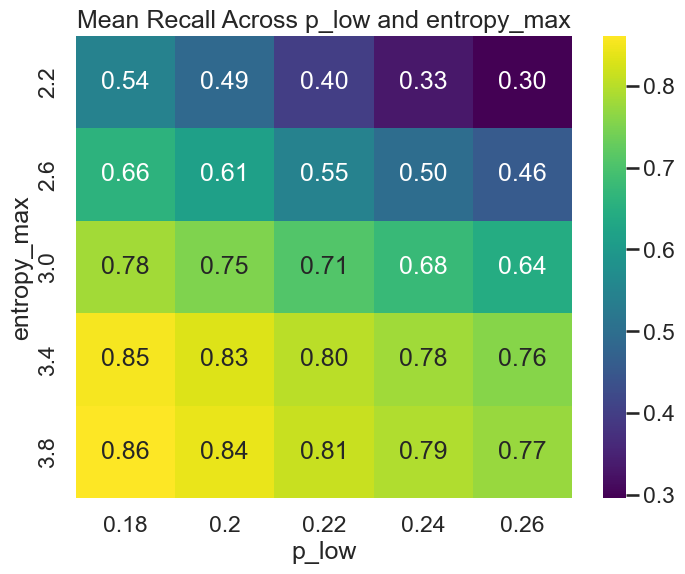

In [29]:
pivot = df.pivot_table(
    values='recall_conf',
    index='entropy_max',
    columns='p_low',
    aggfunc='mean'
)

plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, fmt='.2f', cmap='viridis')
plt.title('Mean Recall Across p_low and entropy_max')
plt.show()
